# DTSA-5511: Week 3 Mini- Project


## Brief description of the problem and data

In this project I will make use of a convolutional nueral network (CNN) in order to detect metatstatic cancer in cells. The data are RGB images, with corresponding labels supplied for the training data. I will run my model on the test data to generate models and validate the test accuracy using Kaggle's submission feature. 
The data are split into two binary exlusive classes. The images are of cells that either do or do not have cancer. In total, there are 220,025 training cases. I chose to use 80% for training, and 20% for validation in accordance with the rule of thumb. The  According to the Kaggle listing, the training data, test data, and labels combined consist of a ~7.75 GB file. There will be some duplication of data in the effort of unzipping the file during download, so if your machine experiences lag after loading, a good intermediate step would be to delete the ZIP file after unzipping.

The individual image files are all .tif files of shape (96, 96, 3). According to the Kaggle listing, the training label is assigned as positive if at least one pixel in the center (32, 32) of an image contains tumorous tissue. The rest of the image is provided to enable CNN with padding schemes / convolution stride that eats away at the exterior of the image. 

The test dataset consists of unlabeled .tif images. The goal of this project is to predict the labels of those test images with the CNN I will build.

## Loading the Data

First we'll load the necessary libraries. Please ensure that you have these installed on your environment before running this notebook.


In [1]:
# Load libraries for project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import cv2 # For EDA
from PIL import Image
import sys

In [4]:
!pwd

/cygdrive/e/CNN-Cancer-Detection


In [6]:
os.listdir(".") #The data have been successfully downloaded. Now we need to unzip.

['.git',
 'README.md',
 'histopathologic-cancer-detection.zip',
 'Week3_CNN_Project.ipynb',
 '.ipynb_checkpoints']

In [7]:
%%capture
!unzip "./histopathologic-cancer-detection.zip"

Archive:  ./histopathologic-cancer-detection.zip

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  inflating: train/091523fd9b2c33f0f59c12e44dab980ca9ee83e3.tif  
  inflating: train/09152cf699e01a8d20253f20c3e5344683005bd6.tif  
  inflating: train/091571365994b1c27da20432f94f595a0cf01cfd.tif  
  inflating: train/0915950b0252cb6b78523b042fa5eb32595bb2e5.tif  
  inflating: train/091620b0429b3fbe7d92add26cf5d86c50c4ffe2.tif  
  inflating: train/09169205adfc3cf9ac75ca2f374e1d1b92ace0c8.tif  
  inflating: train/0917766b740cc2ebd64fadab6ecf0b182b954f2c.tif  
  inflating: train/0917996ade54d26b40f8defb05fc9afec3450923.tif  
  inflating: train/09179ffae72f548039115e05716937bab6cb17ca.tif  
  inflating: train/0917c307758c84bbcd976e259adff719494d30c2.tif  
  inflating: train/0917dae4aa0d135b488af9e4cb2b3dbc4ad6901e.tif  
  inflating: train/09181b0e6ca8e22ae1520ae31deb4a369cc28364.tif  
  inflating: train/0918a57031cedbdd730768662a8baefae805c2e6.tif  
  inflating: train/0918a5a02aaa1e4d3bac7c4c80ec51bee5b1f32e.tif  
  inflating: train/091927f38892f9cb55dfa8754334ff716a0ee286.tif  
  inflatin

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  inflating: train/ffec4a03e0a1b8d70e2bab767ac0f1803519e71a.tif  
  inflating: train/ffed159c92ed2522017bec2d0c786dd0a9aa80fe.tif  
  inflating: train/ffed28cc285263c08dc21a3df06bb5e8ca171768.tif  
  inflating: train/ffed3cd587d97a708c0ad607c874035b837d7013.tif  
  inflating: train/ffed6a9cce174b04b74307dd49749f7706421c76.tif  
  inflating: train/ffede3cc91012724d2fe44320b36f223b71d04e8.tif  
  inflating: train/ffee0b949f0dfdf43249b7cbd8e89526d09e63f5.tif  
  inflating: train/ffee0e6c59b4ad9e735bcfa752f817a7af98faa4.tif  
  inflating: train/ffee40e1d5864d8f46c8c2ea9d0730f194faf956.tif  
  inflating: train/ffef3105722d6da981d24aeb88053be6d8d148d7.tif  
  inflating: train/fff04a619220944155f4c52330c97d56fb44fab4.tif  
  inflating: train/fff04bd771a260738286f1e19509ba238c5e9b3c.tif  
  inflating: train/fff10f1fea361125cf13ddf99e2c91512b6ef92e.tif  
  inflating: train/fff114ec9f0b45352006d493d937151957bbf138.tif  
  inflating: train/fff15e0095b982f7ac45d361bd07442ad738e882.tif  
  inflatin

In [8]:
#Display files in current working directory. Should include test, train, and train_labels
os.listdir("./")

['.git',
 'README.md',
 'histopathologic-cancer-detection.zip',
 'Week3_CNN_Project.ipynb',
 '.ipynb_checkpoints',
 'sample_submission.csv',
 'test',
 '.gitignore',
 'train',
 'train_labels.csv']

## Cleaning

It turns out that all the image files provided in the Kaggle competition have the .tif extension, which Keras dislikes. We will need to convert these to .png in order for Keras to succeed in creating our Data object. I'll write a custom function to do this in a cell chunk below.

In [9]:
def convertToPNG(newDir, oldDir, fileName):
  """
  This function converts a .tif image file from oldDir to a .png and saves it to
  newDir. 
  Input: string filePath
  Output: None
  """
  targetPath = newDir + fileName[:-4] + ".png"
  this_img = Image.open(oldDir + fileName)
  this_img.save(targetPath)
  this_img.close()

In [10]:
# Make necessary containers for converted training images
## with subdirectories for binary classification
dir0train = "./pngContainer/pngTrain/0/"
dir1train = "./pngContainer/pngTrain/1/"
os.makedirs(dir0train)
os.makedirs(dir1train)

#Read in and sort training labels alphanumerically. The sorting is identical
## to the sorting we will perform on the images (they have the same names).
train_labs_df = pd.read_csv("./train_labels.csv")
training_labels = list(train_labs_df.sort_values(by = "id", axis = 0)["label"])

# Convert all .tif files in "./train/" to .png 's . This will take about 10
## minutes total.
train_dir = "./train/"
train_imgs = os.listdir(train_dir)
train_imgs.sort()

#Quick sanity check
assert len(train_imgs) == len(training_labels)

#Populate subdirectories. This will take a while (for me ~ 10 minutes). Grab a
## snack. If there is a better way to do this I'm all ears.
for i in range(len(train_imgs)):
  if training_labels[i] == 0:
    convertToPNG(dir0train, train_dir, train_imgs[i])
  else:
    assert training_labels[i] == 1
    convertToPNG(dir1train, train_dir, train_imgs[i])

In [11]:
#Check that files got properly put in "./pngContainer/pngTrain" and converted to
## .png
os.remove("./histopathologic-cancer-detection.zip")
os.listdir("./pngContainer/pngTrain")

['0', '1']

In [13]:
# Call image_dataset_from_directory to build keras Data object
train_data = tf.keras.utils.image_dataset_from_directory(
    directory = "./pngContainer/pngTrain",
    labels = "inferred",
    label_mode = "binary",
    color_mode = "rgb",
    image_size = (96, 96),
    seed = 42,
    batch_size = 32
)

Found 220025 files belonging to 2 classes.


In [14]:
#Confirm that training data was propertly loaded
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

## Exploratory Data Analysis

I will first show an example photo from the training data, along with its type and shape. 

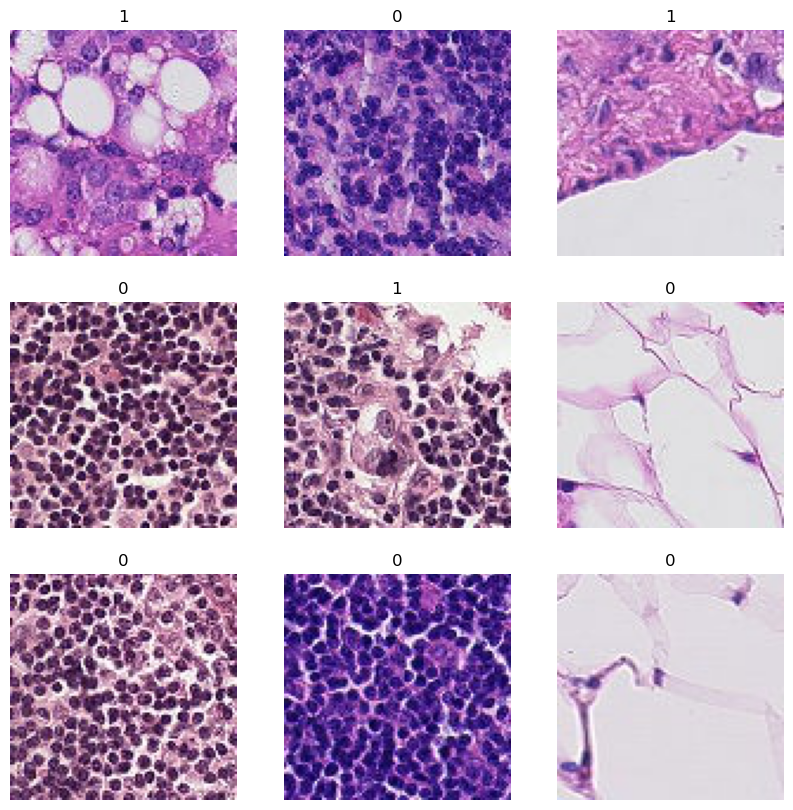

In [15]:
# More Example Images
#Citation https://keras.io/examples/vision/image_classification_from_scratch/

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

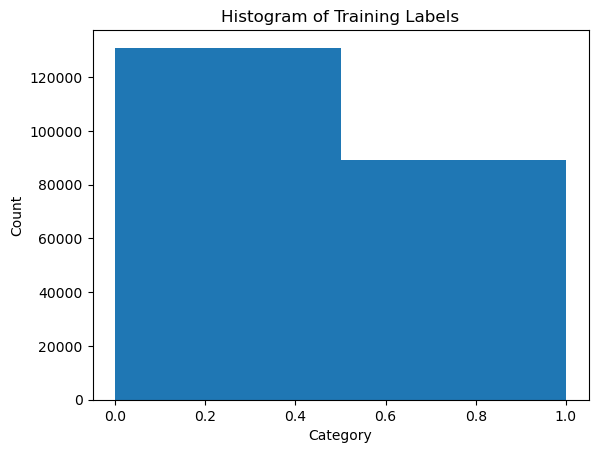

In [16]:
# Make Histogram of Training Labels
plt.hist(training_labels, bins = 2)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Histogram of Training Labels")
plt.show()

I would like to do an EDA that consists of examining the brightness per pixel (max, min, mean) over each of the three RGB channels, but doing so would involve re-loading all of the training data using cv2, which seems like a drastic waste of memory.

## Model Architecture and Construction

I will try a couple different architectures, because CNN architecture itself is a hyperparameter that needs optimization. Keras provides a wonderful API to build simple CNN's in. In particular, the Sequential API is built for single input single output models. We are inputting single images, and want to output a single label, so the Sequential API works perfect. 

We learned in class that the basic effective architecture for a CNN looks like [convolve -> convolve -> maxpool]$_n$, and then fed into a dense ANN for classification. I will use $n = 3$ for my project, because as $n$ increases the CNN develops the ability to "see" more macroscopic trends in the data, which may indicate the present of cancerous tissue. By preventing too many layers, we can try and prevent overfitting.

We learned that either relu or PreLu is the best choice of activation function for hidden layers. The Keras Sequential API doesn't have a built in PreLu, and I fear that any that I implement will be algorthmically inefficient in Python, so I won't worry about optimizing the interem activation functions. We will use (3x3) filters as suggested. I will try both the Adam and RMSProp optimizers, and various values of learning rate between (0.0001, 0.001). I will also use a learning_rate scheduler to minimize variance towards the end of training. I will try Dropout layers in various locations. I will use binary cross entropy as my loss function, because it is the most appropriate for logit outputs from a sigmoid output activation.

All of my hyperparameter tuning will be done manually. The fitting will take a while, but will return the optimal choice of architecture and hyperparameters by validation accuracy.

In [17]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten

def buildaModel(eta, dropout1, dropout2, optimizer):
  """
  This function builds a model according to the hyperparamaters passed. The documentation for keras-tuner is quite poor, and there are many bugs.
  I will just make my own grid searcher.

  Inputs:
    float eta, learning rate
    Boolean dropout1, whether to include dropout layer after first c-c-m
    Boolean dropout2, whether to include dropout layer after second c-c-m
    string optimizer, either "Adam" or "RMSprop"
  
  Output: Keras sequential model object
  """
  batch_input_shape = (32, 96, 96, 3) # Mini-batches are of size 32. Images are of shape (96, 96, 3)
  model = tf.keras.Sequential()
  model.add(BatchNormalization(axis = -1))
  #CNN [c, c, m] Layers
  model.add(Conv2D(32,
                   kernel_size = 3,
                   padding="same",
                   activation = "relu",
                   batch_input_shape = batch_input_shape))
  model.add(Conv2D(32, kernel_size = 3, activation = "relu"))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(BatchNormalization(axis = -1)) #Normalize to prevent overfitting

  model.add(Conv2D(64, kernel_size = 3, activation = "relu"))
  model.add(Conv2D(64, kernel_size = 3, activation = "relu"))
  model.add(MaxPooling2D(pool_size = 2))
  #Decide whether or not to use a Dropout between [c, c, m] instances
  model.add(BatchNormalization(axis = -1)) #Normalize to prevent overfitting

  model.add(Conv2D(128, kernel_size = 3, activation = "relu"))
  model.add(Conv2D(128, kernel_size = 3, activation = "relu"))
  model.add(MaxPooling2D(pool_size = 2))
  #Decide whether or not to use a Dropout between [c, c, m] instances
  model.add(BatchNormalization(axis = -1)) #Normalize to prevent overfitting

  #Now send the model into an ANN for binary classification
  model.add(Flatten())
  if dropout1:
    model.add(Dropout(0.25))
  model.add(Dense(256, activation = "relu"))
  model.add(Dense(128, activation = "relu"))
  if dropout2:
    model.add(Dropout(0.25))
  model.add(Dense(32, activation = "relu"))
  model.add(Dense(1, activation = "sigmoid")) #Output layer

  #Make a learning rate schedule to prevent variance at the end of training
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate = eta,
      decay_steps = 10000,
      decay_rate=0.9
      )
  
  #Compile the model
  if optimizer == "Adam":
    model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
      loss = "binary_crossentropy",
      metrics=["accuracy"]
    )
  else:
    assert optimizer == "RMSprop"
    model.compile(
      optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr_schedule),
      loss = "binary_crossentropy",
      metrics = ["accuracy"]
    )
  return(model)

In [18]:
#Trial model before gridsearch
myModel = buildaModel(eta = 0.001, dropout1 = True, dropout2 = True, optimizer = "Adam")
callbacks_list =  [tf.keras.callbacks.EarlyStopping(monitor="loss", patience = 10, mode = "min")]
history = myModel.fit(train_data,
                      epochs = 99,
                      steps_per_epoch = len(train_data)/100,
                      callbacks = callbacks_list)

print(myModel.summary())

Epoch 1/99
68/68 [==============================] - 63s 569ms/step - loss: 0.6763 - accuracy: 0.7124
Epoch 2/99
68/68 [==============================] - 40s 577ms/step - loss: 0.5992 - accuracy: 0.7233
Epoch 3/99
68/68 [==============================] - 39s 567ms/step - loss: 0.5187 - accuracy: 0.7844
Epoch 4/99
68/68 [==============================] - 39s 575ms/step - loss: 0.4849 - accuracy: 0.7876
Epoch 5/99
68/68 [==============================] - 38s 553ms/step - loss: 0.4744 - accuracy: 0.7989
Epoch 6/99
68/68 [==============================] - 39s 577ms/step - loss: 0.4584 - accuracy: 0.8089
Epoch 7/99
68/68 [==============================] - 39s 575ms/step - loss: 0.4404 - accuracy: 0.8089
Epoch 8/99
68/68 [==============================] - 40s 585ms/step - loss: 0.4229 - accuracy: 0.8207
Epoch 9/99
68/68 [==============================] - 39s 573ms/step - loss: 0.4240 - accuracy: 0.8157
Epoch 10/99
68/68 [==============================] - 42s 607ms/step - loss: 0.4445 - accura

                                                                 
 batch_normalization_3 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
          

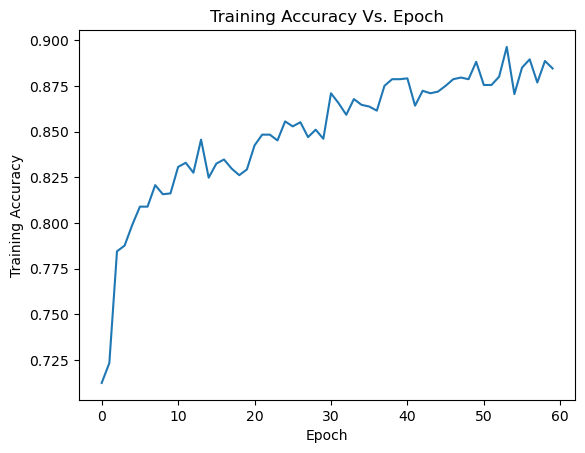

In [19]:
# Make a nice visualization of our test model: Training Accuracy Vs. Epoch
testAccs = history.history["accuracy"]
epochs = [i for i in range(len(testAccs))]
plt.plot(epochs, testAccs)
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy Vs. Epoch")
plt.show()

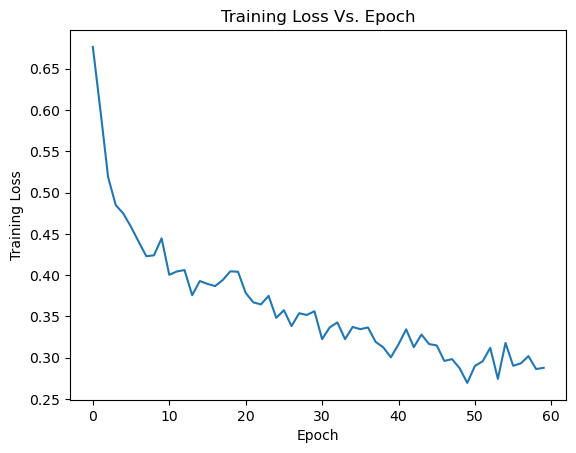

In [20]:
# Make another nice visualization: Loss Vs. Epoch
testLosses = history.history["loss"]
plt.plot(epochs, testLosses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Vs. Epoch")
plt.show()

### Success!

Now that we have confirmed that the model construction function works, we can go about doing our HP optimization. To reiterate, we will choose various initial learning rates and dropout layer inclusions to differentiate our models. The values of $\eta$ that I will initially scan are $\{0.0001, 0.0005, 0.001, 0.005, 0.01\}$. After running these models, I will try some ad hoc values to get try and get the validation accuracy up a bit more. After this I will experiment with dropout layers. I want at least one dropout layers, so I will try permutations with at least one 'True' values. Finally, we will also try changing the optimizer.

This next cell execution will take a while - go grab a snack (or just don't execute it because it is pre-populated in the .ipynb). The total training time for the test model was ~ 3.5 minutes, so over 30 options we would expect 105 minutes of training.

In [21]:
#Perform HP optimization
import itertools
startTime = time.time()
callbacks_list =  [tf.keras.callbacks.EarlyStopping(monitor="loss", patience = 10, mode = "min")]
eta_to_try = [0.0001, 0.001, 0.005, 0.01]
dropouts_to_try = [(True, True)]
optimizers_to_try = ["Adam", "RMSprop"]

hpPermutations = list(itertools.product(*[eta_to_try, dropouts_to_try, optimizers_to_try]))
current_best_model = (None, 0)
current_best_history = None

model_accuracies = list()
for hpList in hpPermutations:
  print("Now trying hyperparams:", hpList)
  this_model = buildaModel(eta = hpList[0],
                           dropout1 = True,
                           dropout2 = True,
                           optimizer = hpList[2]
                           )
  this_history = this_model.fit(train_data,
                                epochs = 99,
                                steps_per_epoch = len(train_data)/100,
                                callbacks = callbacks_list
                                )
  if this_history.history["accuracy"][-1] > current_best_model[1]:
    current_best_model = (this_model, this_history.history["accuracy"][-1])
    current_best_history = this_history.history

endTime = time.time()
print("Total HP optimization time:", round((endTime - startTime)/60, 3), "minutes")

Now trying hyperparams: (0.0001, (True, True), 'Adam')
Epoch 1/99
68/68 [==============================] - 49s 605ms/step - loss: 0.5480 - accuracy: 0.7468
Epoch 2/99
68/68 [==============================] - 42s 604ms/step - loss: 0.5094 - accuracy: 0.7636
Epoch 3/99
68/68 [==============================] - 41s 600ms/step - loss: 0.5352 - accuracy: 0.7582
Epoch 4/99
68/68 [==============================] - 42s 607ms/step - loss: 0.5015 - accuracy: 0.7577
Epoch 5/99
68/68 [==============================] - 40s 581ms/step - loss: 0.4739 - accuracy: 0.7894
Epoch 6/99
68/68 [==============================] - 42s 613ms/step - loss: 0.4931 - accuracy: 0.7754
Epoch 7/99
68/68 [==============================] - 42s 613ms/step - loss: 0.4714 - accuracy: 0.7853
Epoch 8/99
68/68 [==============================] - 42s 606ms/step - loss: 0.4706 - accuracy: 0.7794
Epoch 9/99
68/68 [==============================] - 41s 605ms/step - loss: 0.4580 - accuracy: 0.7889
Epoch 10/99
68/68 [=================

68/68 [==============================] - 40s 576ms/step - loss: 0.4264 - accuracy: 0.8202
Epoch 21/99
68/68 [==============================] - 40s 588ms/step - loss: 0.4123 - accuracy: 0.8193
Epoch 22/99
68/68 [==============================] - 39s 561ms/step - loss: 0.3991 - accuracy: 0.8261
Epoch 23/99
68/68 [==============================] - 40s 589ms/step - loss: 0.3968 - accuracy: 0.8302
Epoch 24/99
68/68 [==============================] - 39s 576ms/step - loss: 0.3984 - accuracy: 0.8265
Epoch 25/99
68/68 [==============================] - 41s 584ms/step - loss: 0.3825 - accuracy: 0.8379
Epoch 26/99
68/68 [==============================] - 40s 583ms/step - loss: 0.4038 - accuracy: 0.8247
Epoch 27/99
68/68 [==============================] - 40s 590ms/step - loss: 0.3879 - accuracy: 0.8379
Epoch 28/99
68/68 [==============================] - 40s 583ms/step - loss: 0.4117 - accuracy: 0.8265
Epoch 29/99
68/68 [==============================] - 43s 640ms/step - loss: 0.4029 - accuracy:

Epoch 41/99
68/68 [==============================] - 88s 1s/step - loss: 0.3157 - accuracy: 0.8673
Epoch 42/99
68/68 [==============================] - 62s 892ms/step - loss: 0.3125 - accuracy: 0.8732
Epoch 43/99
68/68 [==============================] - 44s 630ms/step - loss: 0.3010 - accuracy: 0.8791
Epoch 44/99
68/68 [==============================] - 39s 566ms/step - loss: 0.3472 - accuracy: 0.8524
Epoch 45/99
68/68 [==============================] - 40s 581ms/step - loss: 0.3246 - accuracy: 0.8655
Epoch 46/99
68/68 [==============================] - 41s 601ms/step - loss: 0.3266 - accuracy: 0.8578
Epoch 47/99
68/68 [==============================] - 40s 591ms/step - loss: 0.3101 - accuracy: 0.8714
Epoch 48/99
68/68 [==============================] - 41s 597ms/step - loss: 0.3298 - accuracy: 0.8668
Epoch 49/99
68/68 [==============================] - 40s 591ms/step - loss: 0.3019 - accuracy: 0.8809
Epoch 50/99
68/68 [==============================] - 40s 578ms/step - loss: 0.2645 - 

68/68 [==============================] - 40s 582ms/step - loss: 0.3954 - accuracy: 0.8361
Epoch 35/99
68/68 [==============================] - 40s 575ms/step - loss: 0.3835 - accuracy: 0.8406
Epoch 36/99
68/68 [==============================] - 38s 563ms/step - loss: 0.3905 - accuracy: 0.8406
Epoch 37/99
68/68 [==============================] - 39s 567ms/step - loss: 0.3755 - accuracy: 0.8460
Epoch 38/99
68/68 [==============================] - 39s 566ms/step - loss: 0.3713 - accuracy: 0.8478
Epoch 39/99
68/68 [==============================] - 40s 577ms/step - loss: 0.3856 - accuracy: 0.8329
Epoch 40/99
68/68 [==============================] - 40s 588ms/step - loss: 0.3588 - accuracy: 0.8533
Epoch 41/99
68/68 [==============================] - 39s 568ms/step - loss: 0.3820 - accuracy: 0.8438
Epoch 42/99
68/68 [==============================] - 39s 569ms/step - loss: 0.3799 - accuracy: 0.8379
Epoch 43/99
68/68 [==============================] - 40s 575ms/step - loss: 0.3624 - accuracy:

Epoch 24/99
68/68 [==============================] - 45s 657ms/step - loss: 0.4269 - accuracy: 0.8265
Epoch 25/99
68/68 [==============================] - 45s 649ms/step - loss: 0.4319 - accuracy: 0.8288
Now trying hyperparams: (0.01, (True, True), 'Adam')
Epoch 1/99
68/68 [==============================] - 55s 674ms/step - loss: 1.7370 - accuracy: 0.6359
Epoch 2/99
68/68 [==============================] - 47s 675ms/step - loss: 0.5903 - accuracy: 0.7178
Epoch 3/99
68/68 [==============================] - 44s 638ms/step - loss: 0.5200 - accuracy: 0.7708
Epoch 4/99
68/68 [==============================] - 42s 606ms/step - loss: 0.4610 - accuracy: 0.8003
Epoch 5/99
68/68 [==============================] - 39s 572ms/step - loss: 0.4651 - accuracy: 0.7912
Epoch 6/99
68/68 [==============================] - 41s 593ms/step - loss: 0.4400 - accuracy: 0.8107
Epoch 7/99
68/68 [==============================] - 41s 595ms/step - loss: 0.4534 - accuracy: 0.7998
Epoch 8/99
68/68 [==================

68/68 [==============================] - 2s 29ms/step - loss: 0.4097 - accuracy: 0.8247
Epoch 33/99
68/68 [==============================] - 2s 28ms/step - loss: 0.4245 - accuracy: 0.8406
Epoch 34/99
68/68 [==============================] - 2s 28ms/step - loss: 0.4381 - accuracy: 0.8238
Epoch 35/99
68/68 [==============================] - 2s 29ms/step - loss: 0.4512 - accuracy: 0.8274
Epoch 36/99
68/68 [==============================] - 2s 28ms/step - loss: 0.4062 - accuracy: 0.8270
Epoch 37/99
68/68 [==============================] - 2s 28ms/step - loss: 0.4530 - accuracy: 0.8207
Epoch 38/99
68/68 [==============================] - 2s 28ms/step - loss: 0.4444 - accuracy: 0.8324
Epoch 39/99
68/68 [==============================] - 2s 28ms/step - loss: 0.4457 - accuracy: 0.8261
Epoch 40/99
68/68 [==============================] - 2s 28ms/step - loss: 0.4173 - accuracy: 0.8306
Epoch 41/99
68/68 [==============================] - 2s 28ms/step - loss: 0.4190 - accuracy: 0.8234
Epoch 42/99


In [22]:
# Try best settings with a smaller value for eta and compare
mod = buildaModel(0.0001, True, True, "Adam")
mod.fit(train_data,
        epochs = 99,
        steps_per_epoch = len(train_data)/100,
        callbacks = callbacks_list)

Epoch 1/99
68/68 [==============================] - 3s 26ms/step - loss: 0.5357 - accuracy: 0.7369
Epoch 2/99
68/68 [==============================] - 2s 27ms/step - loss: 0.4915 - accuracy: 0.7704
Epoch 3/99
68/68 [==============================] - 2s 28ms/step - loss: 0.5086 - accuracy: 0.7582
Epoch 4/99
68/68 [==============================] - 2s 29ms/step - loss: 0.4903 - accuracy: 0.7817
Epoch 5/99
68/68 [==============================] - 2s 27ms/step - loss: 0.4747 - accuracy: 0.7849
Epoch 6/99
68/68 [==============================] - 2s 27ms/step - loss: 0.4609 - accuracy: 0.8034
Epoch 7/99
68/68 [==============================] - 2s 27ms/step - loss: 0.4767 - accuracy: 0.7862
Epoch 8/99
68/68 [==============================] - 2s 26ms/step - loss: 0.4499 - accuracy: 0.7994
Epoch 9/99
68/68 [==============================] - 2s 26ms/step - loss: 0.4328 - accuracy: 0.8107
Epoch 10/99
68/68 [==============================] - 2s 27ms/step - loss: 0.4283 - accuracy: 0.8179
Epoch 11/

## Results and Analysis

The model is trained! We performed a grid search over a few hyperparameters, namely various selections of learning rate chosen logarithmically on the set [0.0001, 0.01], and where to use dropout layers.

The metric we optimized against was validation accuracy. I expect the test data to have accuracy approximately equal to the best validation accuracy, because we didn't train the CNN on either set. I'll make visualizations of validation_accuracy vs. epoch, and training loss vs. epoch. I think some great visualizations I'll do for my final will be validation accuracy vs. $\eta$, and execution time vs. validation accuracy. Unfortunately for this project I couldn't get the model.fit() method to accept validation_data, but I found a nice tutorial online where I think I can replicate the results. That's for another day.

After these visualizations I will create label predictions for the test set, then send them to Kaggle for the test accuracy.

I have included the configuration of the best model after HP optimization.

In [23]:
print(current_best_model[0].optimizer)
dir(current_best_model[0])


['_SCALAR_UPRANKING_ON',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_graph_network_for_inferred_shape',
 '_build_input_shape',
 '_call_spec',
 '_callable_losses',
 '_captured_weight_regularizer',
 '_cast_single_input',
 '_check_call_args',
 '_check_sample_weight_warning',
 '_checkpoint',
 '_check

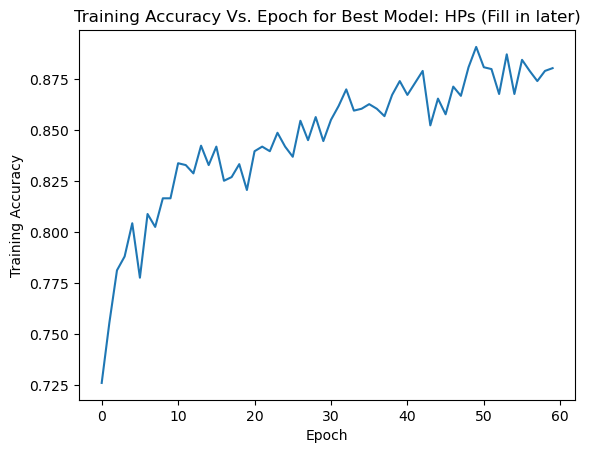

In [24]:
# Make Epochs Vs. Training Accuracy for beest model
accs = current_best_history["accuracy"]
epochs = [i for i in range(len(accs))]

plt.plot(epochs, accs)
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy Vs. Epoch for Best Model: HPs (Fill in later)")
plt.show()

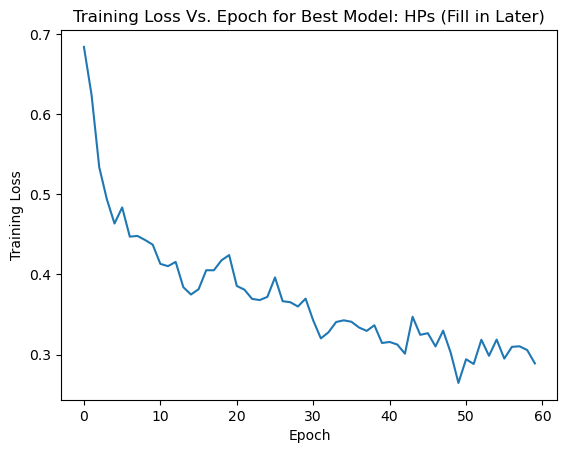

In [25]:
# Make Epochs Vs. Training Loss for best model
loss = current_best_history["loss"]

plt.plot(epochs, loss)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Vs. Epoch for Best Model: HPs (Fill in Later)")
plt.show()

In [27]:
# Make necessary containers for converted test images. This section will be
## basically a mirror of the .tif -> .png conversion done on the training data.
dirTestTarget = "./pngContainer/pngTest/imgs/"
#Note we require .../imgs/ so that there exists a subdirectory for keras to find
os.makedirs(dirTestTarget)
test_dir = "./test/"
test_imgs = os.listdir(test_dir)
test_imgs.sort()

for img in test_imgs:
  convertToPNG(dirTestTarget, test_dir, img)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: './pngContainer/pngTest/imgs/'

In [40]:
# Make test_data as BatchDataset
test_data = tf.keras.utils.image_dataset_from_directory(
    directory = "./pngContainer/pngTest",
    labels = None,
    label_mode = "binary",
    color_mode = "rgb",
    image_size = (96, 96),
    batch_size = 32
)

Found 57458 files belonging to 1 classes.


In [41]:
test_data

<BatchDataset element_spec=TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None)>

In [42]:
# Make Predictions using test_data
yhat = current_best_model[0].predict(test_data)

1796/1796 [==============================] - 135s 75ms/step


In [43]:
test_data.file_paths

['./pngContainer/pngTest\\imgs\\dd24520b39f32e4e8420c7f83cdd285b8c8fcc7a.png',
 './pngContainer/pngTest\\imgs\\00186a82134c399e8bb77d038475741d696cb72b.png',
 './pngContainer/pngTest\\imgs\\99138298bec5e78e083c2476f1d8e00fca8be897.png',
 './pngContainer/pngTest\\imgs\\91307d76623e32d49d99909904a1a7bd2a2e2fb3.png',
 './pngContainer/pngTest\\imgs\\54f2ebd63c8048e6747d427d3d566cf351008940.png',
 './pngContainer/pngTest\\imgs\\30c557612c1b04a8e78dcd671cf42dca18d9e0c5.png',
 './pngContainer/pngTest\\imgs\\7566c63ec9c49fee6d62c3cea66e819fb3e8a74c.png',
 './pngContainer/pngTest\\imgs\\9936ae320d2b1129042332e9a30a57f310c2d49f.png',
 './pngContainer/pngTest\\imgs\\a7fae25f1db43ca6e72af06b77925ec60406bfba.png',
 './pngContainer/pngTest\\imgs\\08d69a9c203793256652a4545d55d16f7187ef68.png',
 './pngContainer/pngTest\\imgs\\6db10a861395362f996f2f151008f2a693012aa4.png',
 './pngContainer/pngTest\\imgs\\bd51eb0cf37f13f78e4faa3f8d334c06cb4071af.png',
 './pngContainer/pngTest\\imgs\\c399737413df356271a6

In [46]:
# Finalize predictions and make csv to submit to Kaggle
yhat = yhat.reshape((yhat.shape[0], ))
label = [round(yhat[i]) for i in range(len(yhat))]
testids = test_data.file_paths
id = [testids[i][28:-4] for i in range(len(testids))]

predDic = {
    "id" : id,
    "label" : label
}
preddf = pd.DataFrame(predDic)

In [48]:
preddf

,id,label
0,dd24520b39f32e4e8420c7f83cdd285b8c8fcc7a,0
1,00186a82134c399e8bb77d038475741d696cb72b,0
2,99138298bec5e78e083c2476f1d8e00fca8be897,0
3,91307d76623e32d49d99909904a1a7bd2a2e2fb3,0
4,54f2ebd63c8048e6747d427d3d566cf351008940,1
...,...,...
57453,2ebc471aee0c6a2b11514c580dbd7687af0ef669,1
57454,b8a8a05d4c30a7cc7b82b76accc8ec0237f543a1,1
57455,a7e7a2cb5b792e3d6326a2b09149f0644acab1ac,0
57456,83e6fb0901faaf3bcfb053659358046d60f7aae4,0


In [51]:
preddf.set_index('id', inplace=True)
preddf

,label
id,
dd24520b39f32e4e8420c7f83cdd285b8c8fcc7a,0
00186a82134c399e8bb77d038475741d696cb72b,0
99138298bec5e78e083c2476f1d8e00fca8be897,0
91307d76623e32d49d99909904a1a7bd2a2e2fb3,0
54f2ebd63c8048e6747d427d3d566cf351008940,1
...,...
2ebc471aee0c6a2b11514c580dbd7687af0ef669,1
b8a8a05d4c30a7cc7b82b76accc8ec0237f543a1,1
a7e7a2cb5b792e3d6326a2b09149f0644acab1ac,0


In [52]:
preddf.to_csv("./submission_1.csv")

## Conclusion

Well that didn't work well. There is some issue with the labels not aligning with the predictions. I can't quite figure out why. The test set accuracy is an abysmal 50%, which is pretty impossible because while it should be as high as the training accuracy, there is no way that the model was just making random guesses, which is what an accuracy of 50% implies. Here's my really poor output.

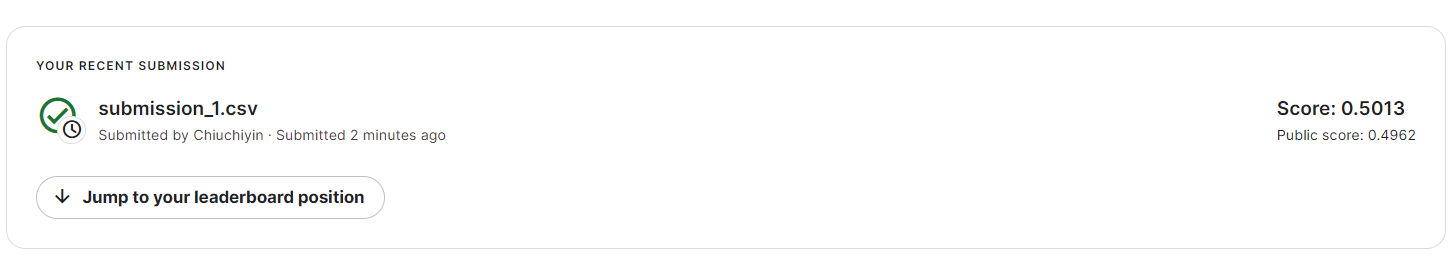

Good thing we aren't being graded on making things work. If any of you know how to properly align the predictions and labels, please let me know!

Some primary takeaways:

A too small eta will have just as negative a performance on the CNN's ability to properly fit as too high an eta. The "Adam" optimizer slightly outperformed the "RMSprop" optimizer, by about 0.05 accuracy points. That's quite significant. The inclusion of multiple dropout layers really helped to prevent overfitting, which was easy to spot when the accuracy began to dip back down / loss asymptoted.

I initially did this project on Kaggle but for some reason it keeps crashing, it totally resets the environment sometimes, which means I had to re-load and re-train all my models many times. Which is very frustrating. So I decided to run my code locally in the end. Perhaps I should work on building good PC to avoid these issues in the future. Thanks for taking the time to review my project, and have a wonderful day.